# UNIVARIATE FORECASTING USING SIMPLE & DEEP RECURRENT NEURAL NETWORKS

_**Univariate time-series forcasting using Simple & Deep Recurrent Neural Networks (RNNs).**_

The following experiment considers Chicago Transit Authority (CTA) dataset (https://data.cityofchicago.org/) containing daily bus and rail ridership. The data from January 01, 2001 through August 1, 2024 was considered in this experiment.

In [1]:
# Imports required packages

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2025-12-04 03:29:35.135190: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-04 03:29:35.135565: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 03:29:35.186525: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 03:29:36.415599: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Data Acquisition

In [2]:
# Loads the dataset
ridership = pd.read_csv(
    "./../data/CTA-Ridership-Daily_Boarding_Totals_20240829.csv", 
    parse_dates=["service_date"]  # Considers column as a date column if it contains date as text
)

# Shows the dataset
display(ridership.head())

,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01,U,297192,126455,423647
1,2001-01-02,W,780827,501952,1282779
2,2001-01-03,W,824923,536432,1361355
3,2001-01-04,W,870021,550011,1420032
4,2001-01-05,W,890426,557917,1448343


**Note:** Attribute value **W**, **A** ans **U** in column **day_type** represent **Weekday**, **Saturday** and **Sunday/Holiday**, respectively.

In [3]:
# Sets the column 'service_date' as index instead of default integer-based index
ridership.set_index("service_date", inplace=True)

In [4]:
# Sorts dataset (in ascending order) by index "service_date" to make index monotonic considering
# it would be a requirement for slicing DataFrame with a datetime type based index
ridership.sort_index(inplace=True)

In [5]:
# Drops the calculated column "total_rides" as this is just element-wise addition 
# between columns "bus" and "rail_boardings".
ridership.drop("total_rides", axis=1, inplace=True)

## Data Analysis

<Axes: xlabel='service_date'>

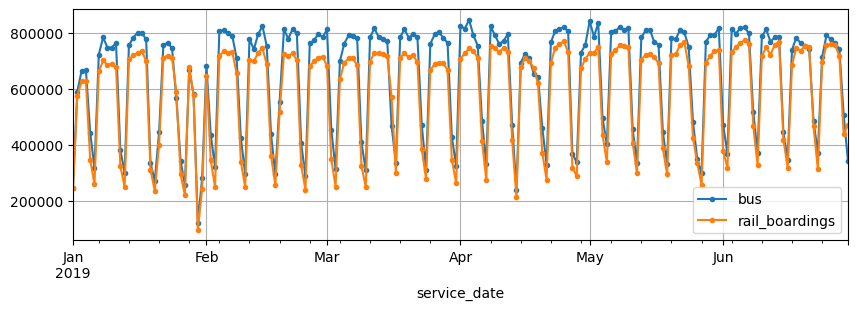

In [6]:
# Plots the bus and rail ridership over a few months in 2019
ridership["2019-01":"2019-06"].plot(grid=True, marker=".", figsize=(10, 3))

Weekly seasonality (repeating pattern) for both variables - bus and rail was observed by looking at the above figure.

## Data Preprocessing

**Prepares Datasets for Modeling**

Prepares input as sequences each containing 56 values from time steps (_t_ – 55) to _t_ for model to output a single value as a forecast for time step (_t_ + 1).

In [7]:
# Splits the time-series into three periods - for training, validation and testing
# The values are scaled down by a factor of one million, to ensure the values are near the 0–1 range

rail_train = ridership["rail_boardings"]["2016-01":"2018-12"] / 1e6  # 3 years
rail_val = ridership["rail_boardings"]["2019-01":"2019-06"] / 1e6    # 6 months
rail_test = ridership["rail_boardings"]["2019-07":] / 1e6            # remaining period from 2019-07 through 2024-04

In [8]:
# Prepares TensorFlow specific datasets

seq_length = 56    # sequence of 56 days of ridership data on which prediction for next day is made on

tf.random.set_seed(42)  # Sets global random seed for operations that rely on a random seed

# Creates train set consists of sequences each containing 56 consecutive data points
rail_train_set = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),           # All consecutive data points (timesteps) converted from series to array
    targets=rail_train[seq_length:], # To set targets[i+seq_length]` as target corresponding to the window that starts at index `i`
    sequence_length=seq_length,      # Length of output sequence
    batch_size=32,                   # Number of sequences in each batch
    shuffle=True,                    # Shuffles the output sequences [required only for training]
    seed=42                          # Random seed for shuffling [required only if shuffling is set to True]
)

# Similarly, prepares validation and test set 
# (without shufflining as it is not required for validation and testing)

rail_val_set = tf.keras.utils.timeseries_dataset_from_array(
    rail_val.to_numpy(),
    targets=rail_val[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

rail_test_set = tf.keras.utils.timeseries_dataset_from_array(
    rail_test.to_numpy(),
    targets=rail_test[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

2025-12-04 03:31:15.772457: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Modeling
_Forecasting next days's rail ridership based (only) on rail ridership [single variable as input] of the past 8 weeks (56 days) using simple and deep RNNs._

### Univariate Forecasting Using a Simple RNN

In [9]:
# Creates a sequential model with an RNN
univar_simple_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),  # None indicates RNN to accept input sequence of any length
    tf.keras.layers.SimpleRNN(32),           # Simple RNN layer with 32 output recurrent neurons
    tf.keras.layers.Dense(1)                 # Output layer with one output neuron
])

In [10]:
# Compiles it with specific loss function, optimizer and metric
univar_simple_rnn.compile(
    loss="huber",                     # Huber loss is popular for RNN for regression task
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=["mae"])

In [11]:
# Fits the model
history = univar_simple_rnn.fit(
    rail_train_set,
    validation_data=rail_val_set, 
    epochs=500, 
    callbacks=[
        # Sets callback to 
        tf.keras.callbacks.EarlyStopping(    #stops training when model does improve after a certain number of training iterations
            monitor="val_mae", 
            patience=50, 
            restore_best_weights=True)
    ])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0228 - mae: 0.1523 - val_loss: 0.0035 - val_mae: 0.0604
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0048 - mae: 0.0699 - val_loss: 0.0028 - val_mae: 0.0530
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0039 - mae: 0.0588 - val_loss: 0.0025 - val_mae: 0.0479
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0038 - mae: 0.0586 - val_loss: 0.0023 - val_mae: 0.0468
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0035 - mae: 0.0567 - val_loss: 0.0021 - val_mae: 0.0412
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0031 - mae: 0.0501 - val_loss: 0.0022 - val_mae: 0.0419
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032 - mae: 0.0531 - val_loss: 0.0018 - val_mae: 0.0341
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0537 - val_loss: 0.0021 - val_mae: 0.0393
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

In [13]:
# After training, model gets evaluated against validation set

val_loss, val_mae = univar_simple_rnn.evaluate(rail_val_set)

print(f"\nValidation loss: {val_loss * 1e6:.4f}, MAE of the Simple RNN: {val_mae * 1e6:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - mae: 0.0293    

Validation loss: 1548.7584, MAE of the Simple RNN: 29316.5706


### Forecasting Using a Deep RNN

Now, checks if deep RNN (multiple layers of Simple RNN) works better than simple RNN.

In [14]:
tf.keras.backend.clear_session()    # Resets all the keras states

tf.random.set_seed(42)

# Creates a Deep RNN with multiple layers of simple RNN each with 32 recurrent neurons 
# followed by a dense output layer with one output neuron
univar_deep_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),  # sequence-to-sequence layer
    tf.keras.layers.SimpleRNN(32, return_sequences=True),  # sequence-to-sequence layer
    tf.keras.layers.SimpleRNN(32),                         # sequence-to-vector layer
    tf.keras.layers.Dense(1)
])

In [15]:
# Compiles the model
univar_deep_rnn.compile(
    loss="huber",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=["mae"])

In [16]:
# Fits the model
history = univar_deep_rnn.fit(
    rail_train_set, 
    validation_data=rail_val_set, 
    epochs=500, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    ])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0573 - mae: 0.2340 - val_loss: 0.0098 - val_mae: 0.1028
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0086 - mae: 0.1020 - val_loss: 0.0038 - val_mae: 0.0647
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0057 - mae: 0.0783 - val_loss: 0.0035 - val_mae: 0.0610
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0050 - mae: 0.0700 - val_loss: 0.0042 - val_mae: 0.0688
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0049 - mae: 0.0678 - val_loss: 0.0026 - val_mae: 0.0497
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0043 - mae: 0.0629 - val_loss: 0.0030 - val_mae: 0.0548
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0045 - mae: 0.0669 - val_loss: 0.0054 - val_mae: 0.0851
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0041 - mae: 0.0609 - val_loss: 0.0023 - val_mae: 0.0444
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - lo

In [18]:
# After training, model gets evaluated against validation data

val_loss, val_mae = univar_deep_rnn.evaluate(rail_val_set)

print(f"\nValidation loss: {val_loss * 1e6:.4f}, MAE of the Deep RNN: {val_mae * 1e6:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - mae: 0.0280    

Validation loss: 1546.2555, MAE of the Deep RNN: 27966.3503


The above performance shows that deep RNN model did little better with validation MAE of ~27966 than the validation MAE of ~29317 of simple RNN model. In the next experiment, multivariate forecasting explored to check if it can improve model performance further.

## Observation

- Text column containing date was first parsed as date-time column in the the dataset. Then that column was set as the dataset index and was make the index monotonic as this property of the dataset will be required for slicing the dataset based on dates to prepare training, validation and test set.

- Weekly seasonality was observed from the plot for both bus and rail ridership.

- Training, validation and test set were preapared by slicing over dates and then target values were scaled down in the range of 0 to 1 for model training.

- 56 days of historical data was used on which next day's prediction to be made.

- TensorFlow dataset was used as an efficient data load for deep learning model traning. Batch size of 32 and shuffling only for traning set were considered. Data from the DataFrame were extracted to NumPy array first for each of the data sets to create respective TensorFlow dataset.

- First a single layer simple RNN was trained with "huber" as loss function and mean absolute error as metric over early stopping and validation loss and validation error were recorded. Then modem with multiple layers of simple RNN was trained over the same settings and its prediction performance was recored.

- It was found that merely adding multiple layers did not improve prediction performance significantly. Hence, multivariate forecasting over univariate forecasting was considered to be experimented next.